In [16]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as clrs
import sklearn

import warnings
warnings.filterwarnings('ignore')

# Make classification

In [17]:
X,y=make_classification(n_samples=200,
                        n_features=2,
                        n_informative=2,
                        n_redundant=0,
                        n_repeated=0,
                        n_clusters_per_class=2,
                        random_state=2)

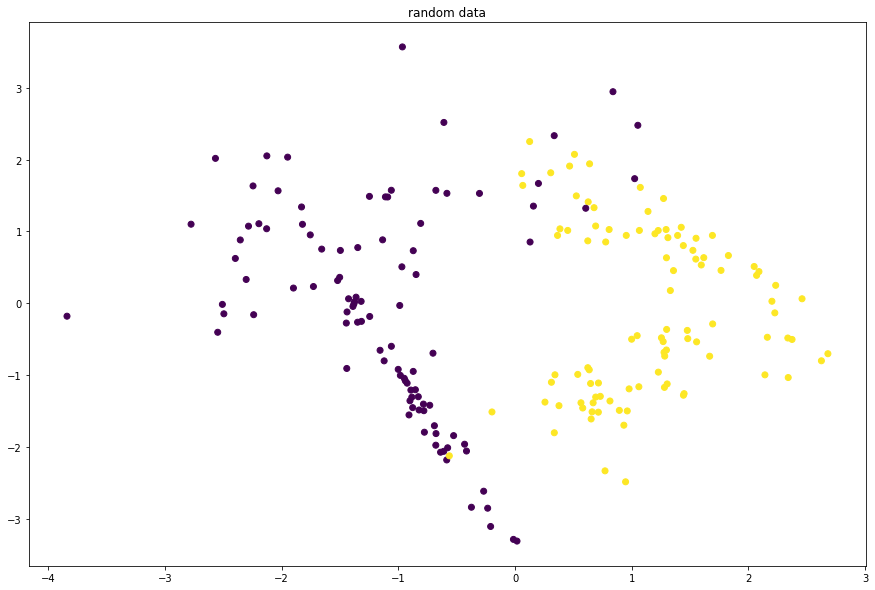

In [18]:
fig,ax=plt.subplots(1,1,figsize=(15,10))

ax.set_title('random data')
ax.scatter(X[:,0],X[:,1],c=y)

plt.show()

# Choose classificators

In [19]:
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, roc_curve
from time import time


classificators=[GaussianNB(),
                QuadraticDiscriminantAnalysis(),
                KNeighborsClassifier(),
                SVC(probability=True),
                DecisionTreeClassifier()]

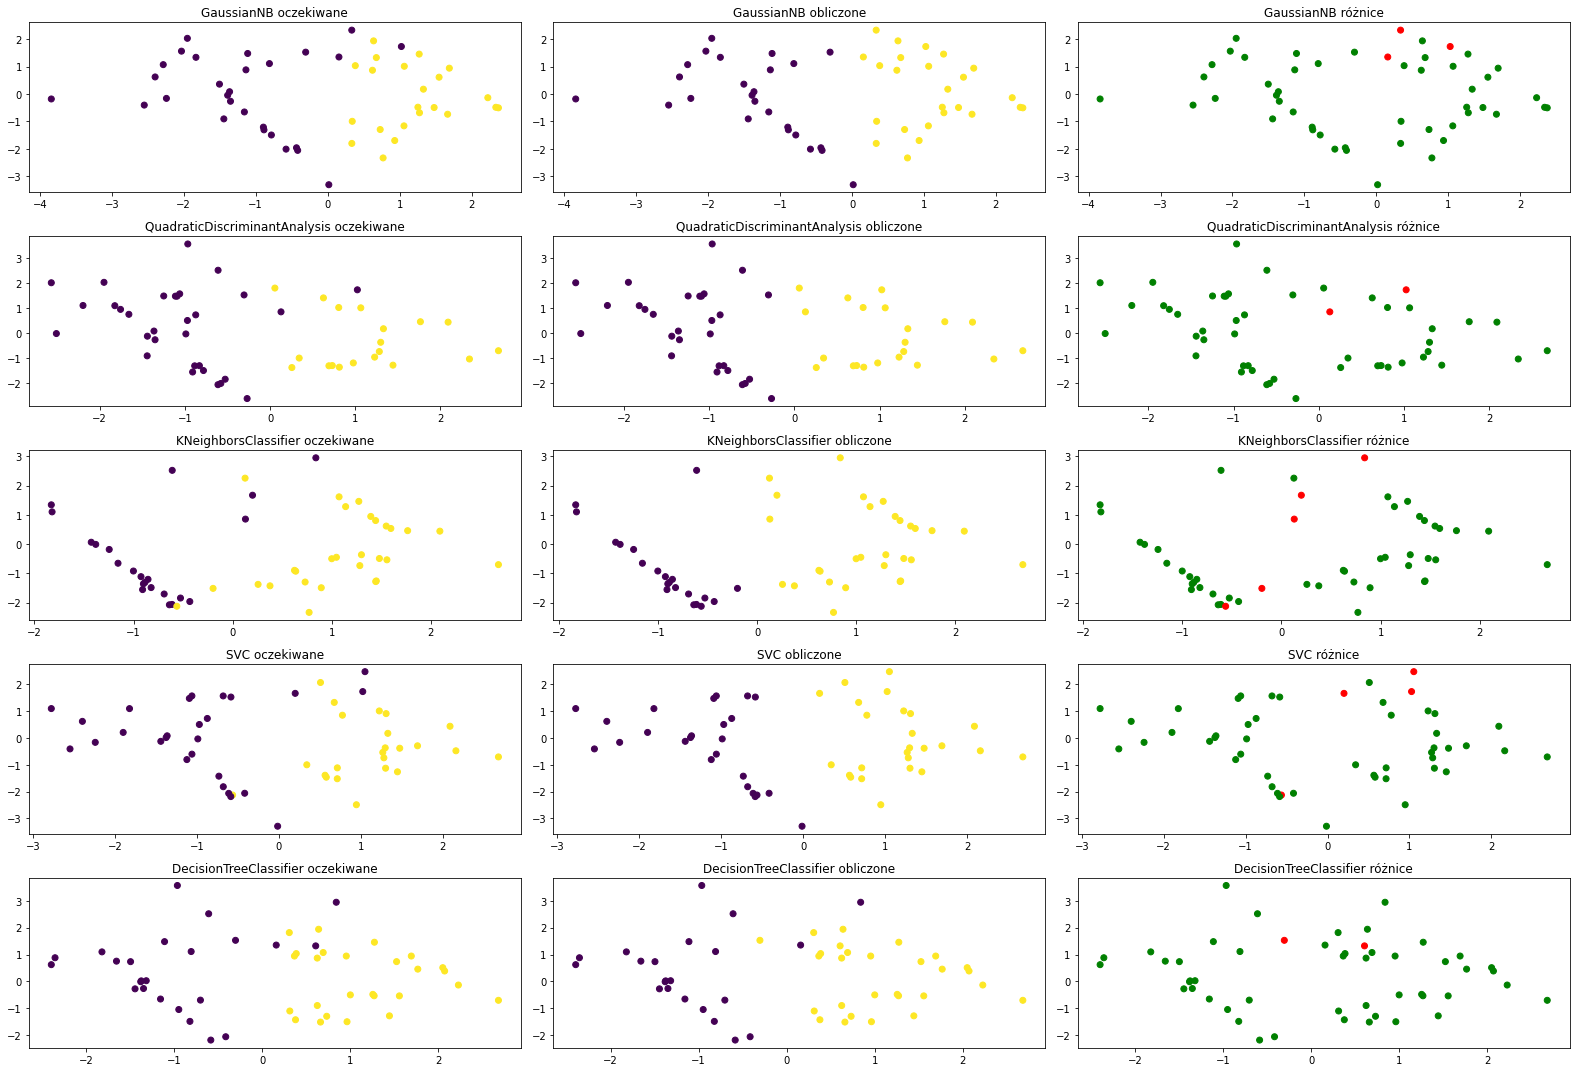

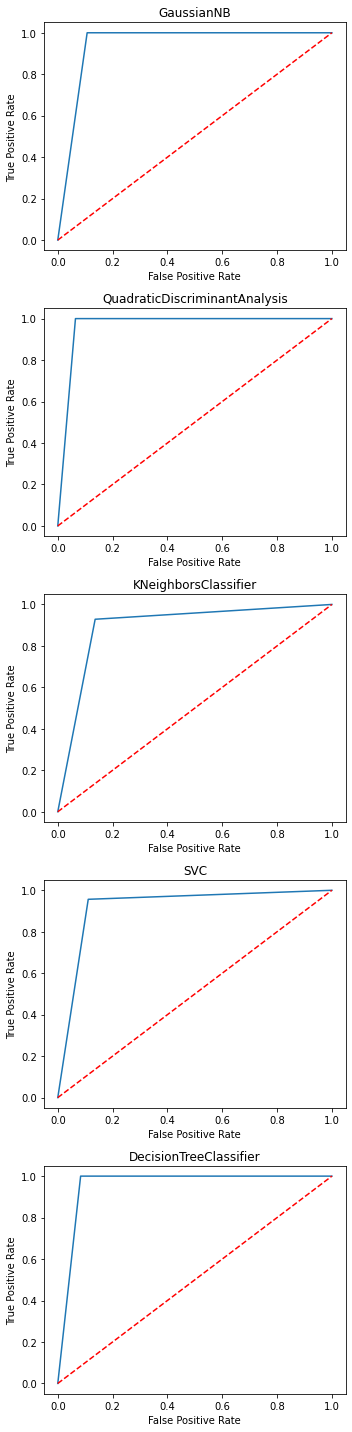

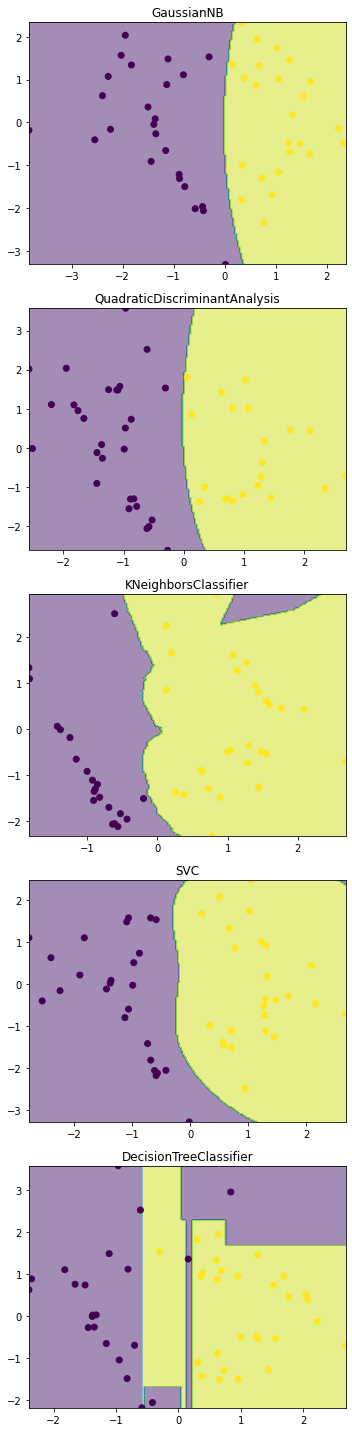

In [20]:
n_iters=100

df=pd.DataFrame()

fig,ax=plt.subplots(5,3,figsize=(22,15))
fig2,ax2=plt.subplots(5,1,figsize=(5,20))
fig3,ax3=plt.subplots(5,1,figsize=(5,20))

for i in range(len(classificators)):
    
    for j in range(n_iters):
        
        X_train, X_test, y_train, y_test = train_test_split(X, y)
        
        t1=time()
        classificators[i].fit(X_train, y_train)
        fit_time=time()-t1
        
        t1=time()
        y_pred = classificators[i].predict(X_test)
        pred_time=time()-t1
        
        acc=accuracy_score(y_test,y_pred)
        rec=recall_score(y_test,y_pred)
        prec=precision_score(y_test,y_pred)
        f1=f1_score(y_test,y_pred)
        roc=roc_auc_score(y_test,y_pred)
        
        name=classificators[i].__class__.__name__
        
        row=pd.Series(
                        {'function':name,
                         'n_iter': j,
                         'fit_time':fit_time,
                         'pred_time':pred_time,
                         'acc':acc,
                         'rec':rec,
                         'prec':prec,
                         'f1':f1,
                         'roc':roc}
        )
        df=df.append(row, ignore_index=True)
        
    ax[i][0].set_title(f'{name} oczekiwane')
    ax[i][0].scatter(X_test[:,0],X_test[:,1],c=y_test)
    
    ax[i][1].set_title(f'{name} obliczone')
    ax[i][1].scatter(X_test[:,0],X_test[:,1],c=y_pred)
     
    ax[i][2].set_title(f'{name} różnice')
    ax[i][2].scatter(X_test[:,0],X_test[:,1],c=y_test==y_pred,cmap = clrs.ListedColormap(['red', 'green']))
    
    #roc_curve
    
    fpr, tpr, thresholds = roc_curve(y_test,y_pred)
    ax2[i].set_title(f'{name}')
    ax2[i].set_xlabel('False Positive Rate')
    ax2[i].set_ylabel('True Positive Rate')
    ax2[i].plot(fpr,tpr)
    ax2[i].plot(fpr[[0,-1]],tpr[[0,-1]],'r--')
    
    #differences
    
    n_points=200
    mesh=np.meshgrid(np.linspace(min(X_test[:,0]),max(X_test[:,0]),n_points) , np.linspace(min(X_test[:,1]),max(X_test[:,1]),n_points))
    data = np.vstack([mesh[0].ravel(),mesh[1].ravel()]).T
    
    predicted=classificators[i].predict(data).reshape(n_points,n_points)
    
    ax3[i].set_title(f'{name}')
    ax3[i].contourf(mesh[0], mesh[1], predicted, alpha=0.5)
    ax3[i].scatter(X_test[:,0], X_test[:,1], c=y_pred)
    
fig.tight_layout()
fig2.tight_layout()
fig3.tight_layout()
plt.show()

In [21]:
final=df.groupby(['function']).mean().drop('n_iter',axis=1)
final

,fit_time,pred_time,acc,rec,prec,f1,roc
function,,,,,,,
DecisionTreeClassifier,0.000301,0.000110,0.9360,0.937737,0.939044,0.936969,0.936642
GaussianNB,0.000469,0.000140,0.9382,0.946895,0.928001,0.936472,0.938204
KNeighborsClassifier,0.000421,0.001505,0.9474,0.968283,0.928936,0.947302,0.947880
QuadraticDiscriminantAnalysis,0.000350,0.000129,0.9422,0.960039,0.928625,0.942967,0.942148
SVC,0.001654,0.000359,0.9448,0.964392,0.927801,0.944541,0.945379


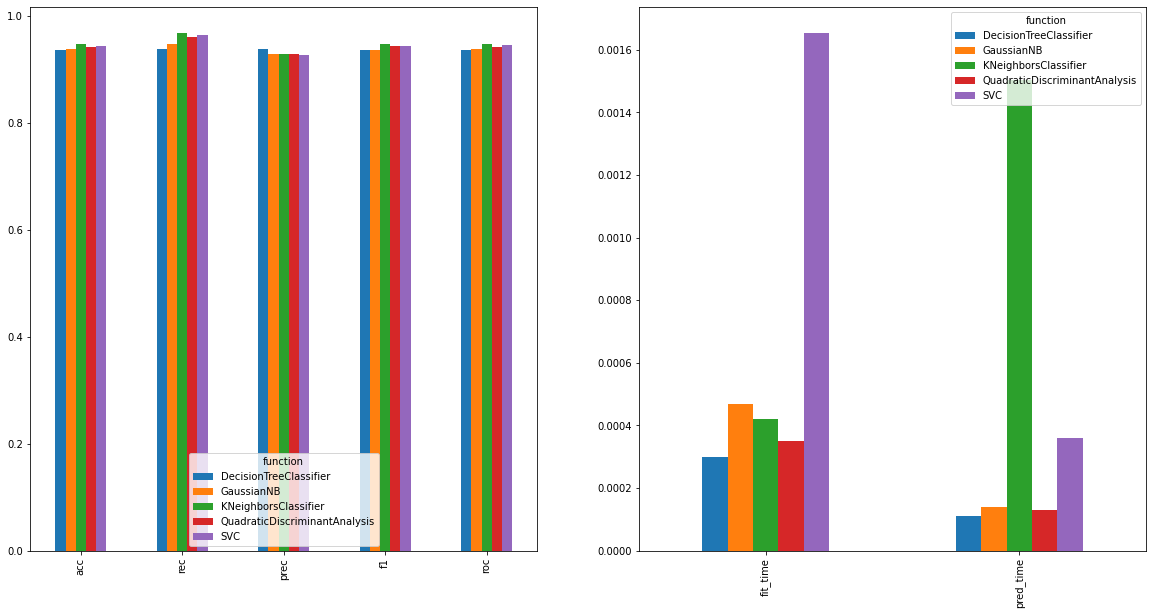

In [22]:
fig,ax=plt.subplots(1,2,figsize=(20,10))


final[['acc', 'rec', 'prec', 'f1', 'roc']].T.plot(kind='bar',ax=ax[0])
final[['fit_time', 'pred_time']].T.plot(kind='bar',ax=ax[1])

plt.show()

# GridSearchCV

In [23]:
X,y=make_classification(n_samples=200,
                        n_features=2,
                        n_informative=2,
                        n_redundant=0,
                        n_repeated=0,
                        n_clusters_per_class=2,
                        random_state=1)


In [24]:
from sklearn.model_selection import GridSearchCV

clf=KNeighborsClassifier()
parameters={'n_neighbors':np.arange(1,20),
            'p':np.arange(1,5,0.25)}

clf=GridSearchCV(estimator=clf, param_grid=parameters, scoring='roc_auc')

In [25]:
clf.fit(X,y)

results=pd.DataFrame(clf.cv_results_)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_p,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.000199,0.000399,0.001396,0.000489,1,1.0,"{'n_neighbors': 1, 'p': 1.0}",0.830827,0.849624,0.85,0.925,0.975,0.88609,0.054964,300
1,0.000593,0.000484,0.002200,0.000747,1,1.25,"{'n_neighbors': 1, 'p': 1.25}",0.830827,0.849624,0.85,0.925,0.975,0.88609,0.054964,300
2,0.000200,0.000399,0.001386,0.000467,1,1.5,"{'n_neighbors': 1, 'p': 1.5}",0.830827,0.849624,0.85,0.925,0.975,0.88609,0.054964,300
3,0.000800,0.000400,0.001195,0.000386,1,1.75,"{'n_neighbors': 1, 'p': 1.75}",0.830827,0.849624,0.85,0.925,0.975,0.88609,0.054964,300
4,0.000399,0.000488,0.000804,0.000402,1,2.0,"{'n_neighbors': 1, 'p': 2.0}",0.830827,0.849624,0.85,0.925,0.975,0.88609,0.054964,300


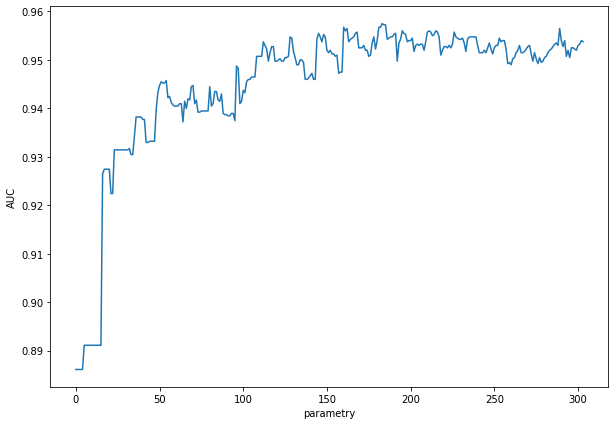

In [26]:
fig,ax=plt.subplots(1,1,figsize=(10,7))

ax.set_xlabel('parametry')
ax.set_ylabel('AUC')
ax.plot(results['mean_test_score'])

plt.show()

In [27]:
n_points=100
keys=list(parameters.keys())
n,m=len(parameters[keys[0]]), len(parameters[keys[1]])


XX=results[f'param_{keys[0]}'].to_numpy().reshape(n,m)
YY=results[f'param_{keys[1]}'].to_numpy().reshape(n,m)
ZZ=results['mean_test_score'].to_numpy().reshape(n,m)

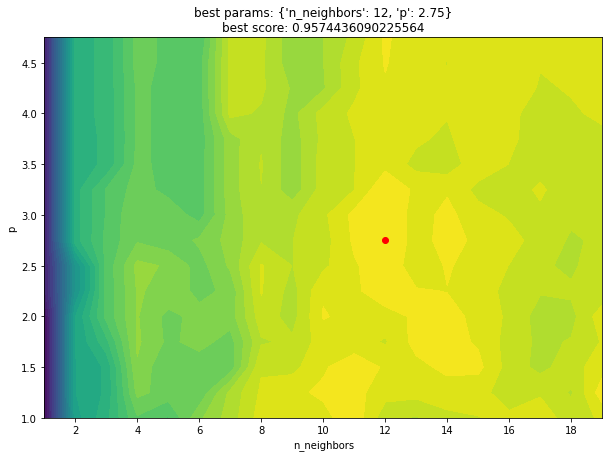

In [28]:
fig,ax=plt.subplots(1,1,figsize=(10,7))

ax.set_xlabel(keys[0])
ax.set_ylabel(keys[1])
ax.set_title(f'best params: {clf.best_params_}\nbest score: {clf.best_score_}')

ax.contourf(XX,YY,ZZ, levels=ZZ.size//10, cmap=plt.cm.viridis)
ax.scatter(clf.best_params_[keys[0]], clf.best_params_[keys[1]], c='r')

plt.show()

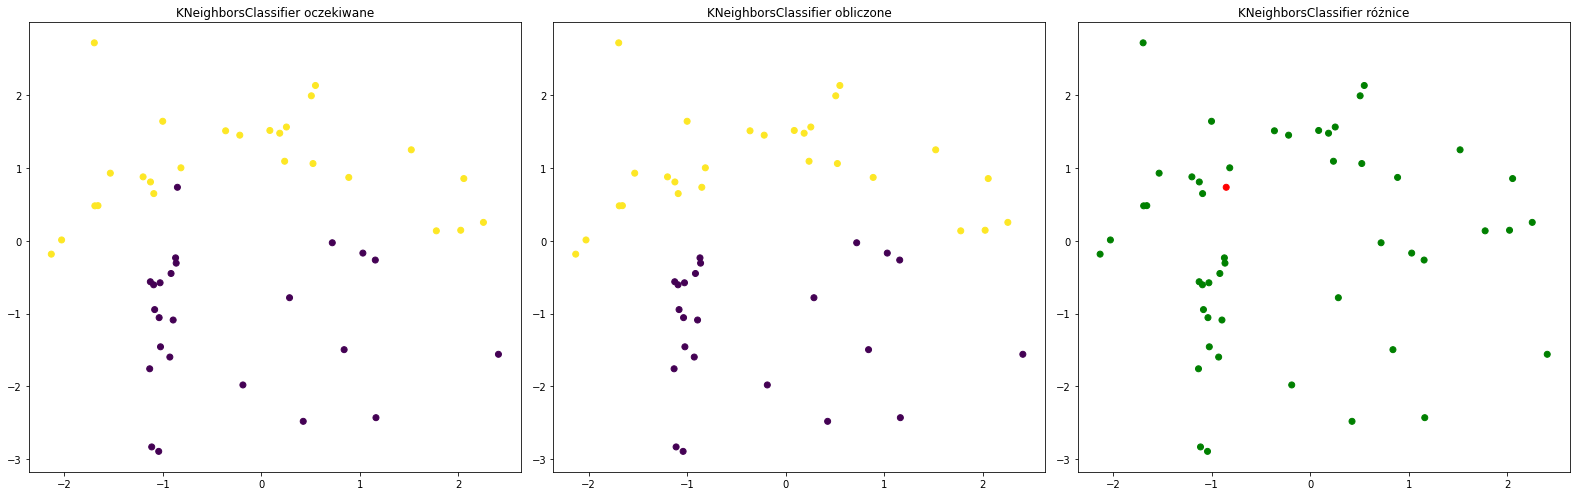

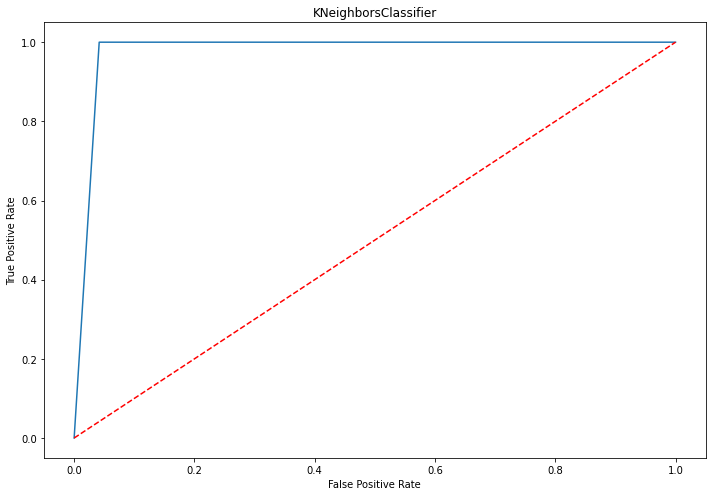

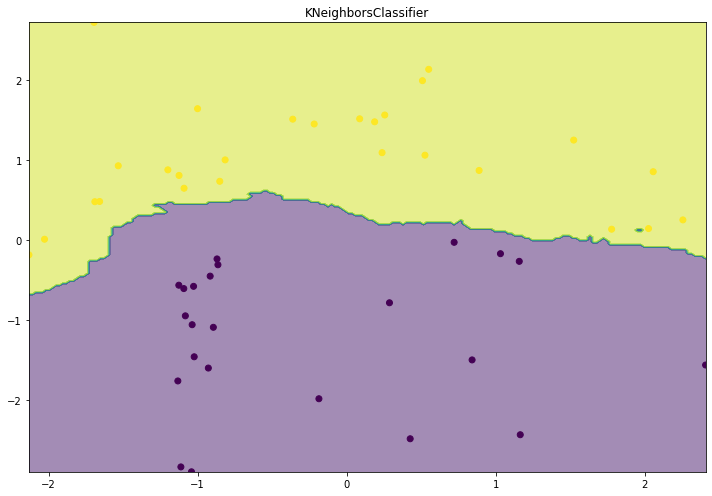

In [31]:
n_iters=100

df=pd.DataFrame()

best_clf=clf.best_estimator_

fig,ax=plt.subplots(1,3,figsize=(22,7))
fig2,ax2=plt.subplots(1,1,figsize=(10,7))
fig3,ax3=plt.subplots(1,1,figsize=(10,7))

    
for j in range(n_iters):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    
    t1=time()
    best_clf.fit(X_train, y_train)
    fit_time=time()-t1
    
    t1=time()
    y_pred = best_clf.predict(X_test)
    pred_time=time()-t1
    
    acc=accuracy_score(y_test,y_pred)
    rec=recall_score(y_test,y_pred)
    prec=precision_score(y_test,y_pred)
    f1=f1_score(y_test,y_pred)
    roc=roc_auc_score(y_test,y_pred)
    
    name=best_clf.__class__.__name__
    
    row=pd.Series(
                    {'function':name,
                        'n_iter': j,
                        'fit_time':fit_time,
                        'pred_time':pred_time,
                        'acc':acc,
                        'rec':rec,
                        'prec':prec,
                        'f1':f1,
                        'roc':roc}
    )
    df=df.append(row, ignore_index=True)
    
ax[0].set_title(f'{name} oczekiwane')
ax[0].scatter(X_test[:,0],X_test[:,1],c=y_test)

ax[1].set_title(f'{name} obliczone')
ax[1].scatter(X_test[:,0],X_test[:,1],c=y_pred)
    
ax[2].set_title(f'{name} różnice')
ax[2].scatter(X_test[:,0],X_test[:,1],c=y_test==y_pred, cmap = clrs.ListedColormap(['red', 'green']))

#roc_curve

fpr, tpr, thresholds = roc_curve(y_test,y_pred)
ax2.set_title(f'{name}')
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.plot(fpr,tpr)
ax2.plot(fpr[[0,-1]],tpr[[0,-1]],'r--')

#differences
n_points=200
mesh=np.meshgrid(np.linspace(min(X_test[:,0]),max(X_test[:,0]),n_points) , np.linspace(min(X_test[:,1]),max(X_test[:,1]),n_points))
data = np.vstack([mesh[0].ravel(),mesh[1].ravel()]).T

predicted=best_clf.predict(data).reshape(n_points,n_points)

ax3.set_title(f'{name}')
ax3.contourf(mesh[0], mesh[1], predicted, alpha=0.5)
ax3.scatter(X_test[:,0], X_test[:,1], c=y_pred)
    
fig.tight_layout()
fig2.tight_layout()
fig3.tight_layout()
plt.show()

In [30]:
final=df.groupby(['function']).mean().drop('n_iter',axis=1)
final

,fit_time,pred_time,acc,rec,prec,f1,roc
function,,,,,,,
KNeighborsClassifier,0.000369,0.001755,0.9044,0.941248,0.880017,0.908262,0.903923
